# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.omf import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import lexicon_memoris, lithology_memoris, pollutant_memoris
from utils.io import boreholes_from_files, gdf_viewer
from core.core import Project
from core.orm import BoreholeOrm, PositionOrm, Base 
import random
from os import remove
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:687: UserWarning: This legend contains duplicate components.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:687: UserWarning: This legend contains duplicate components.
  warnings.warn(w)


## Reading of CSV files in a dir

In [2]:
#df = pd.read_csv('test_data_boreholes.csv', sep=',') # use english lexicon
df = pd.read_csv('test_litho_fr.csv', sep=',') # use french lexicon

## Data Checking

In [3]:
#pol = ['As', 'Ni', 'Cl', 'Hg', 'Pb', 'Zn']
pol = ['VR','VS','VI']
#df[['Pollutant', 'Concentration']] = ''
df[['Pollutant', 'Concentration']] = ''
df['Pollutant'] = df['Pollutant'].apply(lambda x: random.sample(pol, 1)[0])
df['Concentration'] = df['Concentration'].apply(lambda x: np.random.randint(0,100))
df['Unit'] = 'mg/l'

In [4]:
df['Lithology'] = df['Lithology'].replace({'Grès':'Marne', 'Calcaire':'Dolomie'})

In [5]:
df.loc[35.5, :] = ['BH007',152794.0, 121111.0, 60.0, 0.57, 45, 'Calcaire', 'Bleu', 4, 41, 45, 'Cl', 78, 'mg/l']
df.loc[25.5, :] = ['BH005',152473.0, 121460.0, 72.0, 0.61, 32, 'Schiste', 'gris', 3, 29, 32, 'Cl', 78, 'mg/l']
df.drop(index=4, inplace=True)
df.drop(columns='Colour', inplace=True)
df = df.sort_index().reset_index(drop=True)

In [6]:
gdf_viewer(df)

Rows : 996, columns : 13


interactive(children=(IntSlider(value=10, description='rows', max=996, min=10, readout=False), IntSlider(value…

## Create Boreholes from dataframes or files

In [7]:
bhs_df=[df[0:50]] # list of dataframes

In [8]:
boreholes, components, link_intv_comp = boreholes_from_files(bhs_df, verbose=False,
                                                litho_field=['Lithology', 'Pollutant'], 
                                                color_field='Colour', lexicon=lexicon_memoris, 
                                                diam_field='Diameter', thick_field='Thickness')


Dataframe 0 processing...
|__ID:'BH001'
{'lithology': 'sable', 'pollutant': 'vi'}
{'lithology': 'argile', 'pollutant': 'vr'}
{'lithology': 'marne', 'pollutant': 'vi'}
{'lithology': 'charbon', 'pollutant': 'vs'}
Summary : [Striplog(4 Intervals, start=0.0, stop=28.0)]
|__ID:'BH002'
{'lithology': 'sable', 'pollutant': 'vs'}
{'lithology': 'argile', 'pollutant': 'vs'}
{'lithology': 'marne', 'pollutant': 'vr'}
{'lithology': 'charbon', 'pollutant': 'vr'}
{'lithology': 'dolomie', 'pollutant': 'vr'}
Summary : [Striplog(5 Intervals, start=0.0, stop=37.0)]
|__ID:'BH003'
{'lithology': 'sable', 'pollutant': 'vs'}
{'lithology': 'argile', 'pollutant': 'vr'}
{'lithology': 'marne', 'pollutant': 'vs'}
{'lithology': 'charbon', 'pollutant': 'vi'}
{'lithology': 'dolomie', 'pollutant': 'vr'}
Summary : [Striplog(5 Intervals, start=0.0, stop=18.0)]
|__ID:'BH004'
{'lithology': 'sable', 'pollutant': 'vi'}
{'lithology': 'argile', 'pollutant': 'vr'}
{'lithology': 'marne', 'pollutant': 'vr'}
{'lithology': 'charbo

/home/yanathan/Projects/GSDMA/utils/io.py:469: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   The 'overlaps' parameter may be used to remove this warning.
  boreholes.append(BoreholeOrm(id=bh_name))
/home/yanathan/Projects/GSDMA/utils/io.py:469: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.int_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Intervals.id to

In [9]:
boreholes

[<core.orm.BoreholeOrm>(Name=BH001, Length=28.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=32.0, Diameter=0.61, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=45.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=14.0, Diameter=0.31, Intervals=4)]

In [10]:
components

{0: Component({'lithology': 'marne', 'pollutant': 'vi'}),
 1: Component({'lithology': 'charbon', 'pollutant': 'vs'}),
 2: Component({'lithology': 'sable', 'pollutant': 'vi'}),
 3: Component({'lithology': 'argile', 'pollutant': 'vr'}),
 4: Component({'lithology': 'dolomie', 'pollutant': 'vr'}),
 5: Component({'lithology': 'marne', 'pollutant': 'vr'}),
 6: Component({'lithology': 'sable', 'pollutant': 'vs'}),
 7: Component({'lithology': 'argile', 'pollutant': 'vs'}),
 8: Component({'lithology': 'charbon', 'pollutant': 'vr'}),
 9: Component({'lithology': 'charbon', 'pollutant': 'vi'}),
 10: Component({'lithology': 'marne', 'pollutant': 'vs'}),
 11: Component({'lithology': 'dolomie', 'pollutant': 'vs'}),
 12: Component({'lithology': 'schiste'}),
 13: Component({'lithology': 'dolomie', 'pollutant': 'vi'}),
 14: Component({'lithology': 'argile', 'pollutant': 'vi'}),
 15: Component({'lithology': 'calcaire'}),
 16: Component({'lithology': 'sable', 'pollutant': 'vr'})}

In [11]:
len(boreholes), len(components)

(10, 17)

## Create a project and save data in a database

In [12]:
remove('tmp_files/tfe_orm_db.db')

In [13]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [14]:
Base.metadata.create_all(engine)

2021-07-03 22:12:54,614 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-03 22:12:54,614 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-07-03 22:12:54,614 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-03 22:12:54,615 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-07-03 22:12:54,615 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-03 22:12:54,616 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Positions")
2021-07-03 22:12:54,616 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-03 22:12:54,616 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Positions")
2021-07-03 22:12:54,616 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-03 22:12:54,617 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("IntervalData")
2021-07-03 22:12:54,617 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-03 22:12:54,618 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("IntervalData")
2021-07-03 22:12:54,618 INFO sqlalchemy.engine.E

In [15]:
Session = sessionmaker(bind=engine)
session = Session()

## Define project legend(s) and default attribute for representation

In [16]:
p = Project(session, lexicon=lexicon_memoris, repr_attribute='lithology',
            legend_dict={'lithology':{'legend':lithology_memoris}, 'pollutant':{'legend':pollutant_memoris}},)

2021-07-03 22:12:54,666 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-03 22:12:54,669 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-03 22:12:54,670 INFO sqlalchemy.engine.Engine [generated in 0.00094s] ()


In [17]:
p.add_components(components)

2021-07-03 22:12:54,676 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-07-03 22:12:54,677 INFO sqlalchemy.engine.Engine [generated in 0.00121s] ((0, 'Marne, vi'), (1, 'Charbon, vs'), (2, 'Sable, vi'), (3, 'Argile, vr'), (4, 'Dolomie, vr'), (5, 'Marne, vr'), (6, 'Sable, vs'), (7, 'Argile, vs')  ... displaying 10 of 17 total bound parameter sets ...  (15, 'Calcaire'), (16, 'Sable, vr'))
2021-07-03 22:12:54,679 INFO sqlalchemy.engine.Engine COMMIT
2021-07-03 22:12:54,682 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-03 22:12:54,683 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-03 22:12:54,684 INFO sqlalchemy.engine.Engine [cached since 0.01447s ago] ()


Add boreholes into the project

In [18]:
for bh in boreholes:
    p.add_borehole(bh)

2021-07-03 22:12:54,691 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-03 22:12:54,693 INFO sqlalchemy.engine.Engine [generated in 0.00142s] ('BH001', 28.0, 0.43)
2021-07-03 22:12:54,694 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-07-03 22:12:54,695 INFO sqlalchemy.engine.Engine [generated in 0.00095s] ((0, 101.0, 101.0, 101.0, 152600.0, 121039.0), (1, 97.0, 97.0, 97.0, 152600.0, 121039.0), (2, 97.0, 97.0, 97.0, 152600.0, 121039.0), (3, 93.0, 93.0, 93.0, 152600.0, 121039.0), (4, 93.0, 93.0, 93.0, 152600.0, 121039.0), (5, 81.0, 81.0, 81.0, 152600.0, 121039.0), (6, 81.0, 81.0, 81.0, 152600.0, 121039.0), (7, 73.0, 73.0, 73.0, 152600.0, 121039.0))
2021-07-03 22:12:54,697 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-07-03 22:12:54,698 INFO sqlalchemy.e

2021-07-03 22:12:54,764 INFO sqlalchemy.engine.Engine [cached since 0.04842s ago] (8,)
2021-07-03 22:12:54,766 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:54,766 INFO sqlalchemy.engine.Engine [cached since 0.04788s ago] (9,)
2021-07-03 22:12:54,768 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:54,769 INFO sqlalchemy.engine.Engine [cached since 0.05293s ago] (10,)
2021-07-03 22:12:54,770 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

2021-07-03 22:12:54,821 INFO sqlalchemy.engine.Engine [cached since 0.1053s ago] (22,)
2021-07-03 22:12:54,822 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:54,823 INFO sqlalchemy.engine.Engine [cached since 0.1047s ago] (23,)
2021-07-03 22:12:54,825 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:54,826 INFO sqlalchemy.engine.Engine [cached since 0.1098s ago] (24,)
2021-07-03 22:12:54,826 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-07-03 22:12:54,877 INFO sqlalchemy.engine.Engine [cached since 0.1608s ago] (36,)
2021-07-03 22:12:54,878 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:54,878 INFO sqlalchemy.engine.Engine [cached since 0.1598s ago] (37,)
dict_keys(['lithology', 'pollutant'])
[0, 1, 2, 3, 4]
Borehole geometry created successfully !
2021-07-03 22:12:54,887 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-03 22:12:54,887 INFO sqlalchemy.engine.Engine [cached since 0.14s ago] (96.0, 'BH004')
2021-07-03 22:12:54,889 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-03 22:12:54,889 INFO sqlalchemy.engine.Engine [cached since 0.198s ago] ('B

Borehole geometry created successfully !
2021-07-03 22:12:54,935 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-03 22:12:54,936 INFO sqlalchemy.engine.Engine [cached since 0.1887s ago] (97.0, 'BH005')
2021-07-03 22:12:54,937 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-03 22:12:54,938 INFO sqlalchemy.engine.Engine [cached since 0.2464s ago] ('BH006', 26.0, 0.31)
2021-07-03 22:12:54,938 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-07-03 22:12:54,939 INFO sqlalchemy.engine.Engine [cached since 0.2446s ago] ((50, 101.0, 101.0, 101.0, 152375.0, 121002.0), (51, 100.0, 100.0, 100.0, 152375.0, 121002.0), (52, 100.0, 100.0, 100.0, 152375.0, 121002.0), (53, 98.0, 98.0, 98.0, 152375.0, 121002.0), (54, 98.0, 98.0, 98.0, 152375.0, 121002.0), (55, 92.0, 92.0, 92.0, 152375.0, 121002.0), (56, 92.0, 92.0, 92.0, 152375.0, 12100

2021-07-03 22:12:54,991 INFO sqlalchemy.engine.Engine COMMIT
2021-07-03 22:12:54,994 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-03 22:12:54,996 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-03 22:12:54,996 INFO sqlalchemy.engine.Engine [cached since 0.3268s ago] ()
2021-07-03 22:12:54,998 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-03 22:12:54,999 INFO sqlalchemy.engine.Engine [cached since 0.2889s ago] ('BH007',)
2021-07-03 22:12:55,001 INFO sqlalchemy.engine.Engine SELECT

2021-07-03 22:12:55,050 INFO sqlalchemy.engine.Engine [cached since 0.3401s ago] ('BH008',)
2021-07-03 22:12:55,051 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:55,052 INFO sqlalchemy.engine.Engine [cached since 0.336s ago] (72,)
2021-07-03 22:12:55,054 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:55,054 INFO sqlalchemy.engine.Engine [cached since 0.3359s ago] (73,)
2021-07-03 22:12:55,056 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positio

2021-07-03 22:12:55,104 INFO sqlalchemy.engine.Engine [cached since 0.386s ago] (85,)
2021-07-03 22:12:55,106 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:55,106 INFO sqlalchemy.engine.Engine [cached since 0.3903s ago] (86,)
2021-07-03 22:12:55,107 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-03 22:12:55,108 INFO sqlalchemy.engine.Engine [cached since 0.3893s ago] (87,)
2021-07-03 22:12:55,109 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-07-03 22:12:55,160 INFO sqlalchemy.engine.Engine [cached since 0.4417s ago] (99,)
dict_keys(['lithology', 'pollutant'])
[0, 1, 2, 3]
Borehole geometry created successfully !


In [19]:
p.add_link_between_components_and_intervals(link_intv_comp)

2021-07-03 22:12:55,177 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-03 22:12:55,178 INFO sqlalchemy.engine.Engine [cached since 0.4311s ago] (95.0, 'BH10')
2021-07-03 22:12:55,181 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (int_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-07-03 22:12:55,181 INFO sqlalchemy.engine.Engine [generated in 0.00075s] ((0, 2, ''), (1, 3, ''), (2, 0, ''), (3, 1, ''), (4, 6, ''), (5, 7, ''), (6, 5, ''), (7, 8, '')  ... displaying 10 of 50 total bound parameter sets ...  (48, 0, ''), (49, 1, ''))
2021-07-03 22:12:55,183 INFO sqlalchemy.engine.Engine COMMIT
2021-07-03 22:12:55,186 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-03 22:12:55,187 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-03 22:12:55,188 INFO sqlalchemy.engine.Engine [cached since

In [20]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes))

2021-07-03 22:12:55,195 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  10


In [21]:
p.boreholes

2021-07-03 22:12:55,200 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-03 22:12:55,202 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-07-03 22:12:55,202 INFO sqlalchemy.engine.Engine [generated in 0.00062s] ('BH001',)
2021-07-03 22:12:55,204 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-03 22:12:55,204 INFO sqlalchemy.engine.Engine [cached since 0.4942s ago] ('BH001',)
2021-07-03 22:12:55,206 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_

2021-07-03 22:12:55,245 INFO sqlalchemy.engine.Engine [cached since 0.5349s ago] ('BH10',)


[<core.orm.BoreholeOrm>(Name=BH001, Length=97.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=98.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=100.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=96.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=97.0, Diameter=0.61, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH006, Length=100.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=97.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=98.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=94.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=95.0, Diameter=0.31, Intervals=4)]

In [22]:
p.refresh(verbose=False)

2021-07-03 22:12:55,251 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-03 22:12:55,251 INFO sqlalchemy.engine.Engine [cached since 0.5822s ago] ()


In [23]:
session.close()

2021-07-03 22:12:55,257 INFO sqlalchemy.engine.Engine ROLLBACK


# 2D/3D Display

In [24]:
attributes = list(p.legend_dict.keys())
attributes

['lithology', 'pollutant']

-----------
 {'lithology': {'legend': Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
Decor({'_colour': '#d5e6cc', 'width': 3, 'hatch': "'---'", 'component': Component({'lithology': 'argile'})})
Decor({'_colour': '#7ba1a8', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'marne'})})
Decor({'_colour': '#000000', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'charbon'})})
Decor({'_colour': '#fdaffe', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'dolomie'})})
Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
Decor({'_colour': '#149eff', 'width': 3, 'hatch': "'='", 'component': Component({'lithology': 'calcaire'})})), 'cmap': <matplotlib.colors.ListedColormap object at 0x7fd54fb5c3d0>, 'values': ['sable', 'argile', 'marne', 'charbon', 'dolomie', 'schiste', 'calcaire']}, 'pollutant': {'legend': Legend(Decor({'_colou

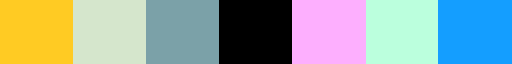

In [25]:
p.update_legend_cmap(update_all_attrib=True)[0][attributes[0]]['cmap']

In [26]:
p.legend_dict#[attributes[0]]['cmap']

{'lithology': {'legend': Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
  Decor({'_colour': '#d5e6cc', 'width': 3, 'hatch': "'---'", 'component': Component({'lithology': 'argile'})})
  Decor({'_colour': '#7ba1a8', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'marne'})})
  Decor({'_colour': '#000000', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'charbon'})})
  Decor({'_colour': '#fdaffe', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'dolomie'})})
  Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
  Decor({'_colour': '#149eff', 'width': 3, 'hatch': "'='", 'component': Component({'lithology': 'calcaire'})})),
  'cmap': <matplotlib.colors.ListedColormap at 0x7fd54fb5c3d0>,
  'values': ['sable',
   'argile',
   'marne',
   'charbon',
   'dolomie',
   'schiste',
   'calcaire']},
 'pollutant': {'legend': Legend

## Display one object (attribute = 'lithology')

In [27]:
bh = 1
p.boreholes_3d[bh]._components

[Component({'lithology': 'sable', 'pollutant': 'vs'}),
 Component({'lithology': 'argile', 'pollutant': 'vs'}),
 Component({'lithology': 'marne', 'pollutant': 'vr'}),
 Component({'lithology': 'charbon', 'pollutant': 'vr'}),
 Component({'lithology': 'dolomie', 'pollutant': 'vr'})]

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/striplog.py:1505: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect1 = patches.Rectangle((0, 0),


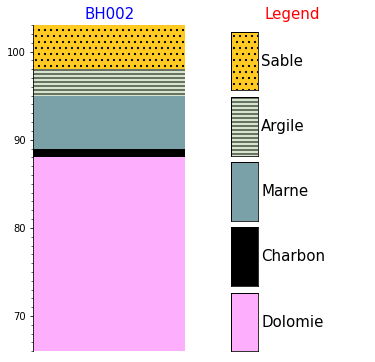

In [28]:
p.boreholes_3d[bh].log_plot()

In [29]:
sargs = dict(title='test', title_font_size=30, label_font_size=12, n_labels=0,
             fmt="%.2f", font_family="arial", color='k',interactive=True, 
             vertical=True, italic=True, shadow=False,)

In [30]:
bh=1
p.boreholes_3d[bh].plot3d(show_legend=False, scalar_bar_args=sargs)

{0.4: 'sable', 1.2000000000000002: 'argile', 2.0: 'marne', 2.8000000000000003: 'charbon', 3.6: 'dolomie'}
5


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Plot with another attribute

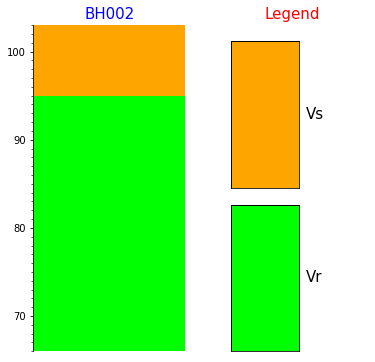

In [31]:
p.boreholes_3d[bh].log_plot(repr_attribute='pollutant')#, repr_legend=pollutant_memoris)

In [32]:
p.boreholes_3d[bh].plot3d(repr_attribute='pollutant')#, repr_legend=pollutant_memoris, show_legend=True)

{0.25: 'vs', 0.75: 'vr'}
2


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Display project boreholes

In [33]:
p.plot3d(repr_attribute='pollutant', labels_size=15, bg_color=["royalblue", "aliceblue"], window_size=(1300, 1000))

Colormap computing ...
{0.25: 'vi', 0.75: 'vr', 1.25: 'vs'}
4
Colormap computing ...
{0.125: 'vs', 0.375: 'vr'}
4
Colormap computing ...
{0.25: 'vs', 0.75: 'vr', 1.25: 'vi'}
4
Colormap computing ...
{0.25: 'vi', 0.75: 'vr', 1.25: 'vs'}
4
Colormap computing ...
{0.25: 'vi', 0.75: 'vs', 1.25: 'Inconnu'}
4
Colormap computing ...
{0.25: 'vi', 0.75: 'vs', 1.25: 'vr'}
4
Colormap computing ...
{0.375: 'vi', 1.125: 'vr', 1.875: 'vs', 2.625: 'Inconnu'}
4
Colormap computing ...
{0.25: 'vr', 0.75: 'vs', 1.25: 'vi'}
4
Colormap computing ...
{0.25: 'vi', 0.75: 'vs', 1.25: 'vr'}
4
Colormap computing ...
{0.125: 'vs', 0.375: 'vi'}
4


### Boreholes in 3D using X3D for interaction within the notebook